In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import hvplot.pandas as hvplot
plt.style.use('seaborn')
!pip install ta
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
import ta as ta
# Initial imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pathlib import Path
import pandas as pd
def download(ticker):
# Note: We could have period < 60d and an intraday return
# Just change period to < 60 days and add interval = 1h
    df = yf.download(ticker, 
                period = '60d', # A period of 2 years from today
                prepost = False, # Pre and Post markets included
                threads = True, # Multi-thread processing for faster output.
                interval = '15m')
    return df
df = download("TSLA")
df = df[['Open','High','Low','Volume','Close']]
#data cleaning
print(df.describe())
print(df.isna().sum())


[*********************100%***********************]  1 of 1 completed
              Open         High          Low        Volume        Close
count  1557.000000  1557.000000  1557.000000  1.557000e+03  1557.000000
mean    728.256837   731.482311   724.816817  1.261087e+06   728.169623
std      81.733283    81.334800    82.154936  1.039055e+06    81.772530
min     546.390015   562.619995   539.489990  0.000000e+00   546.710022
25%     673.880005   676.750000   670.500000  6.373750e+05   673.500000
50%     702.035522   704.769897   699.549988  9.563000e+05   701.989807
75%     799.032104   801.640015   796.200012  1.519822e+06   798.880005
max     895.599976   900.400024   888.504272  1.390479e+07   895.619995
Open      0
High      0
Low       0
Volume    0
Close     0
dtype: int64


In [6]:
# Define the features set 'X', and the target 'y' set.
X = df.iloc[:, 0:4].values
y = df.iloc[:, 4:5].values
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM RNN model.
model = Sequential()

number_units = 32
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
# Summarize the model
model.summary()
model.fit(X_train, y_train, epochs=5, shuffle=False, batch_size=3, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4, 32)             4352      
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 32)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 4, 32)             8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 32)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 4, 32)             8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 32)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)               

In [7]:
model.evaluate(X_test, y_test)
# Make some predictions
predicted = model.predict(X_test)

15/15 [==============================] - 2s 4ms/step - loss: 0.0123


In [8]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

<AxesSubplot:xlabel='Datetime'>

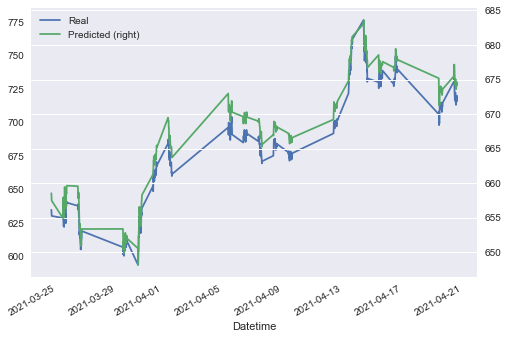

In [10]:
predicted_prices.shape
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()
stocks.plot(secondary_y = 'Predicted')